# TMS/Neuronavigation Project
## .bag file reading

In this notebook, we will read RGBD data from an example bag file, `raj_face.bag`, in Python for (supposed) later manipulation.
This notebook is heavily based off of [this example notebook](https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/distance_to_object.ipynb) from the librealsense library examples/documentation.

## Prerequisites
-----

### 1) Install python dependencies to Colab

In [1]:
!pip install pyrealsense2

     |████████████████████████████████| 9.7MB 2.7MB/s 


### 2) Download .bag data file from Duke Box

In [2]:
!wget -nc -O raj_face.bag https://duke.box.com/shared/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag

--2020-10-17 06:11:58--  https://duke.box.com/shared/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
Resolving duke.box.com (duke.box.com)... 107.152.26.197
Connecting to duke.box.com (duke.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag [following]
--2020-10-17 06:11:58--  https://duke.box.com/public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
Reusing existing connection to duke.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://duke.app.box.com/public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag [following]
--2020-10-17 06:11:58--  https://duke.app.box.com/public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
Resolving duke.app.box.com (duke.app.box.com)... 107.152.26.201
Connecting to duke.app.box.com (duke.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

### Python Imports

In [3]:
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import cv2                                # state of the art computer vision algorithms library
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Python requirements imported successfully.")

Python requirements imported successfully.


## Data Decoding & Visualization
-----

### Reading data from .bag file

In [4]:
BAG_FILENAME = "raj_face.bag"

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(BAG_FILENAME)
profile = pipe.start(cfg)

# --------------- #
# SKIP 150 frames (150 is arbitrary; just to skip to somewhere in middle of video)
for x in range(150):
    pipe.wait_for_frames()
# --------------- #
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print(f"{BAG_FILENAME} frame data read successfully")

raj_face.bag frame data read successfully


### RGB decoding/visualization

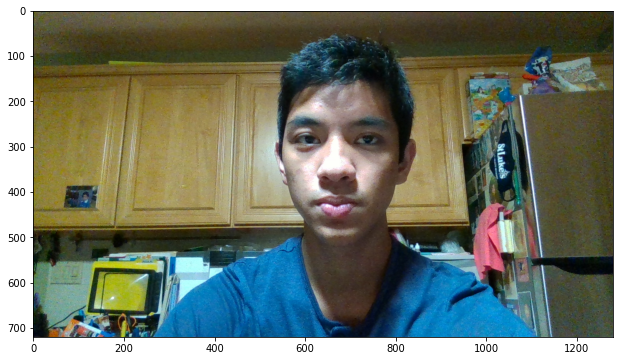

In [5]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

### Align Depth to RGB

In [6]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(rs.colorizer().colorize(aligned_depth_frame).get_data())

### RGBD Visualization (Aligned)

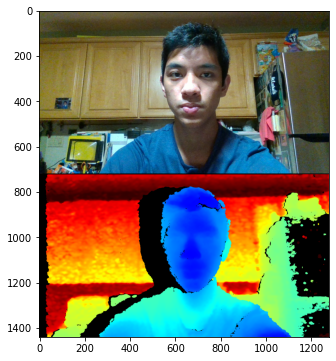

In [7]:
plt.imshow(np.vstack((color, colorized_depth)))